In [1]:
import sys
sys.path.append('./../')

import pickle
import copy
import torch
import time
import numpy as np
np.set_printoptions(precision = 4)

from datasets.dataset import _load_collection_real,_load_collection_syn
from models_utility.construct_models import _initialize_SMkernelhyp,_make_gpmodel
from models_utility.param_gp import Param



from kernels.RBF_kernel import RBF
from kernels.SM_kernel import SM
from scipy.linalg import norm as fnorm


from utility.eval_metric import _evaluate_metric
import matplotlib.pyplot as plt



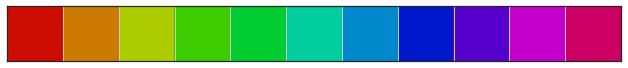

In [2]:
import seaborn as sns
sns.set()
sns.set_style('white')



plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

current_palette = sns.color_palette(sns.hls_palette(10+1, l=.4, s=1.0))
sns.palplot(current_palette)
current_palette = np.asarray(current_palette)

In [3]:
import scipy.io as sio

def _load_syn(filename,cuda_option):
    device = torch.device('cuda:0' if cuda_option else 'cpu')    
    Dataset = sio.loadmat('./datasets/synthetic/' + filename + '.mat')
    x_train, x_test, y_train, y_test , x_full, y_full = Dataset['x_train'], Dataset['x_test'],Dataset['y_train'], Dataset['y_test'],Dataset['x_full'], Dataset['y_full']
    x_train, x_test, y_train, y_test, x_full,y_full = np.float64(x_train), np.float64(x_test) , np.float64(y_train), np.float64(y_test), np.float64(x_full), np.float64(y_full)
    return torch.from_numpy(x_train).to(device),torch.from_numpy(x_test).to(device),torch.from_numpy(x_full).to(device),\
           torch.from_numpy(y_train).to(device),torch.from_numpy(y_test).to(device),torch.from_numpy(y_full).to(device),Dataset


In [4]:
random_seed = 1000
device = True

filename = 'SM_Q2_exp1'
x_train, x_test, x_full, y_train, y_test,y_full,Dataset = _load_syn(filename, cuda_option=device)




In [5]:
setting_dict = {}
setting_dict['random_seed'] = random_seed
setting_dict['init_sample_num'] = 500
setting_dict['input_dim'] = 1

setting_dict['Num_Q'] = 2
setting_dict['num_sample_pt'] = 10
setting_dict['num_batch'] = 1

setting_dict['lr_hyp'] = 0.01        

setting_dict['kl_option'] = True   
setting_dict['iter'] = 6000       
setting_dict['num_rep'] = 1
setting_dict['weight_rate'] = 0.1  
setting_dict['noise_err'] = 0.005*y_train.std()



setting_dict = _initialize_SMkernelhyp( x_train,y_train, setting_dict, random_seed)


In [6]:
ith_model_name = 'equal_reg'
model = _make_gpmodel(model_name=ith_model_name, setting_dict=setting_dict, device=device)
model._set_data(x_train,y_train)

In [7]:
optimizable_param =  [*model.parameters(),model.likelihood.variance]
optimizable_param

[sf2 : tensor([0.], device='cuda:0'), weight : tensor([[0.],
         [0.]], device='cuda:0'), std : tensor([[-0.9912],
         [ 2.8183]], device='cuda:0'), mu : tensor([[-0.4389],
         [ 3.1371]], device='cuda:0'), std_prior : tensor([[-3.3422],
         [-6.1309]], device='cuda:0'), mu_prior : tensor([[-2.2000],
         [-2.4192]], device='cuda:0'), noise_variance : tensor([-5.4225], device='cuda:0')]

In [8]:
optimizer = torch.optim.Adam(optimizable_param ,
                               lr=setting_dict['lr_hyp'],
                               betas=(0.9, 0.99),
                               eps=1e-08,
                               weight_decay=0.0)

In [9]:
observe_period = 100

In [10]:
for i in range(setting_dict['iter'] + 1):
    ith_tic = time.time()    
    optimizer.zero_grad()    
    ith_loss = model.compute_loss(batch_x=x_train, batch_y=y_train, kl_option=setting_dict['kl_option'])        
    ith_loss.backward()
    optimizer.step()

    
    
    with torch.no_grad():
        pred_train_mu, pred_train_var = model._predict(inputs_new=x_train)
        pred_test_mu, pred_test_var = model._predict(inputs_new=x_test)

    # out1 : root mean square (rmse)
    # out2 : mean negative log likelihood (mnll)
    ith_rmse,ith_mnll = _evaluate_metric(pred_test_mu, pred_test_var, y_test)

    if i % observe_period == 0 :
        print('%d th loss0 : %.4f, test rmse : %.4f, test mnll: : %.4f' % (i,ith_loss.cpu().data.numpy(),ith_rmse,ith_mnll))
        try:
            print('self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance')            
            print(model.weight.exp().squeeze(),model.mu.exp().squeeze(),model.std.exp().squeeze(),model.likelihood.variance.transform()**2)

            print('\n')
            print('self.num_samplept_list_at')
            print(model.num_samplept_list_at)
        except:
            pass
        
        print('')

    
    




0 th loss0 : 95456404.8282, test rmse : 1.5854, test mnll: : 61709.4668
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.0101, 0.9900], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([ 0.6383, 23.2684], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([ 0.3674, 16.5819], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([1.9897e-05], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[10, 10]

100 th loss0 : 70705532.8138, test rmse : 0.8001, test mnll: : 4035.0390
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.3826, 0.5194], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([ 0.6169, 20.8253], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([ 0.3196, 13.8407], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([7.6792e-05], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[10, 10]

200 th loss0 : 51246117.9377, test rmse : 1.6067, test mnll: : 7217.6596
self.weight.exp(),se

1900 th loss0 : 25695.1527, test rmse : 11.6161, test mnll: : 100.0443
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([30.3725, 15.9205], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.6384, 0.4083], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.1977, 0.3722], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.1125], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[10, 10]

2000 th loss0 : 15545.2758, test rmse : 4.2693, test mnll: : 33.9015
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([50.9468, 28.5747], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.6387, 0.3266], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.1888, 0.2859], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0899], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[10, 10]

2100 th loss0 : 8716.2558, test rmse : 11.0581, test mnll: : 63.2185
self.weight.exp(),self.mu.exp(),self.std.

3800 th loss0 : -752.6016, test rmse : 0.1155, test mnll: : -0.7142
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([  41.5269, 3073.0694], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.8725, 0.1220], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0341, 0.0381], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0095], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[10, 10]

3900 th loss0 : -883.1369, test rmse : 0.1093, test mnll: : -0.7947
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([  35.8409, 3791.2931], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.8699, 0.1229], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0325, 0.0365], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0092], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[10, 10]

4000 th loss0 : -882.7549, test rmse : 0.1279, test mnll: : -0.5899
self.weight.exp(),self.mu.exp(),self.s

5700 th loss0 : -946.1349, test rmse : 0.1029, test mnll: : -0.8525
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([3.2701e+00, 5.6844e+05], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.8764, 0.1176], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0208, 0.0311], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0097], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[10, 10]

5800 th loss0 : -988.1338, test rmse : 0.1147, test mnll: : -0.7338
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([2.8493e+00, 7.8734e+05], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.8625, 0.1139], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0222, 0.0295], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0090], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[10, 10]

5900 th loss0 : -680.7556, test rmse : 0.2184, test mnll: : 0.8905
self.weight.exp(),self.mu.exp(),sel

# approximate prediction 
## SM kernel Recovery test

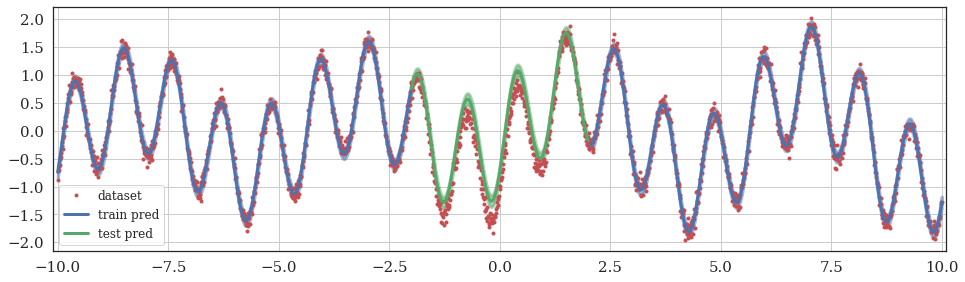

(array(0.2502), array(1.3895))

In [13]:
x_train_l = x_train[x_train <= 0].view(-1,1)
x_train_r = x_train[x_train > 0].view(-1,1)
y_train_l = y_train[x_train <= 0].view(-1,1)
y_train_r = y_train[x_train > 0].view(-1,1)


with torch.no_grad():
    pred_train_mu_l, pred_train_var_l = model._predict(inputs_new=x_train_l)
    pred_train_mu_r, pred_train_var_r = model._predict(inputs_new=x_train_r)
    
    pred_test_mu, pred_test_var = model._predict(inputs_new = x_test, diag=True)    
        

plt.figure(figsize=(16,4.5))
plt.plot(x_train_l.cpu().data.numpy(),y_train_l.cpu().data.numpy(),'r.',label = 'dataset')    
plt.plot(x_train_l.cpu().data.numpy(),pred_train_mu_l.cpu().data.numpy(),'b',linewidth = 3,label = 'train pred')
plt.fill_between( x_train_l.cpu().data.numpy().squeeze(),
                  pred_train_mu_l.cpu().data.numpy().squeeze() - np.sqrt(pred_train_var_l.cpu().data.numpy()).squeeze(),
                  pred_train_mu_l.cpu().data.numpy().squeeze() + np.sqrt(pred_train_var_l.cpu().data.numpy()).squeeze(),
                  alpha = 0.5, edgecolor = 'b', facecolor = 'b',linewidth = 3)

plt.plot(x_train_r.cpu().data.numpy(),y_train_r.cpu().data.numpy(),'r.')    
plt.plot(x_train_r.cpu().data.numpy(),pred_train_mu_r.cpu().data.numpy(),'b',linewidth = 3)
plt.fill_between( x_train_r.cpu().data.numpy().squeeze(),
                  pred_train_mu_r.cpu().data.numpy().squeeze() - np.sqrt(pred_train_var_r.cpu().data.numpy()).squeeze(),
                  pred_train_mu_r.cpu().data.numpy().squeeze() + np.sqrt(pred_train_var_r.cpu().data.numpy()).squeeze(),
                  alpha = 0.5, edgecolor = 'b', facecolor = 'b',linewidth = 3)


plt.plot(x_test.cpu().data.numpy(),y_test.cpu().data.numpy(),'r.')
plt.plot(x_test.cpu().data.numpy(),pred_test_mu.cpu().data.numpy(),'g',linewidth = 3,label = 'test pred')
plt.fill_between( x_test.cpu().data.numpy().squeeze(),
                  pred_test_mu.cpu().data.numpy().squeeze() - np.sqrt(pred_test_var.cpu().data.numpy()).squeeze(),
                  pred_test_mu.cpu().data.numpy().squeeze() + np.sqrt(pred_test_var.cpu().data.numpy()).squeeze(),
                  alpha = 0.5, edgecolor = 'g', facecolor = 'g',linewidth = 3)


plt.xlim([-10-.1,10+.1])    
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 12)
plt.show()

_evaluate_metric(pred_train_mu, pred_train_var, y_train)
_evaluate_metric(pred_test_mu, pred_test_var, y_test)    


# exact prediction 

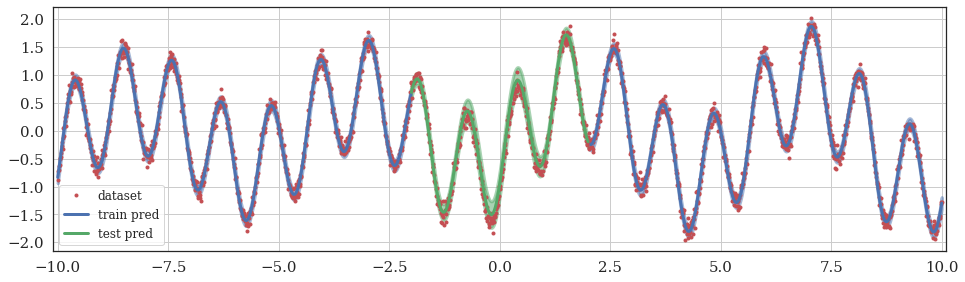

(array(0.1219), array(-0.6092))

In [14]:
with torch.no_grad():
    pred_train_mu_l, pred_train_var_l = model._predict_exact(inputs_new=x_train_l)
    pred_train_mu_r, pred_train_var_r = model._predict_exact(inputs_new=x_train_r)
    
    pred_test_mu, pred_test_var = model._predict_exact(inputs_new = x_test, diag=True)    
    

plt.figure(figsize=(16,4.5))
plt.plot(x_train_l.cpu().data.numpy(),y_train_l.cpu().data.numpy(),'r.',label = 'dataset')    
plt.plot(x_train_l.cpu().data.numpy(),pred_train_mu_l.cpu().data.numpy(),'b',linewidth = 3,label = 'train pred')
plt.fill_between( x_train_l.cpu().data.numpy().squeeze(),
                  pred_train_mu_l.cpu().data.numpy().squeeze() - np.sqrt(pred_train_var_l.cpu().data.numpy()).squeeze(),
                  pred_train_mu_l.cpu().data.numpy().squeeze() + np.sqrt(pred_train_var_l.cpu().data.numpy()).squeeze(),
                  alpha = 0.5, edgecolor = 'b', facecolor = 'b',linewidth = 3)

plt.plot(x_train_r.cpu().data.numpy(),y_train_r.cpu().data.numpy(),'r.')    
plt.plot(x_train_r.cpu().data.numpy(),pred_train_mu_r.cpu().data.numpy(),'b',linewidth = 3)
plt.fill_between( x_train_r.cpu().data.numpy().squeeze(),
                  pred_train_mu_r.cpu().data.numpy().squeeze() - np.sqrt(pred_train_var_r.cpu().data.numpy()).squeeze(),
                  pred_train_mu_r.cpu().data.numpy().squeeze() + np.sqrt(pred_train_var_r.cpu().data.numpy()).squeeze(),
                  alpha = 0.5, edgecolor = 'b', facecolor = 'b',linewidth = 3)


plt.plot(x_test.cpu().data.numpy(),y_test.cpu().data.numpy(),'r.')
plt.plot(x_test.cpu().data.numpy(),pred_test_mu.cpu().data.numpy(),'g',linewidth = 3,label = 'test pred')
plt.fill_between( x_test.cpu().data.numpy().squeeze(),
                  pred_test_mu.cpu().data.numpy().squeeze() - np.sqrt(pred_test_var.cpu().data.numpy()).squeeze(),
                  pred_test_mu.cpu().data.numpy().squeeze() + np.sqrt(pred_test_var.cpu().data.numpy()).squeeze(),
                  alpha = 0.5, edgecolor = 'g', facecolor = 'g',linewidth = 3)


plt.xlim([-10-.1,10+.1])    
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 12)
plt.show()

_evaluate_metric(pred_train_mu, pred_train_var, y_train)
_evaluate_metric(pred_test_mu, pred_test_var, y_test)    
